# Config

In [1]:
import numpy as np
import base64
import os
from os.path import join
import sys

def mprint(msg):
    from datetime import datetime
    """info"""
    cur_time = datetime.now().strftime('%m-%d %H:%M:%S')
    print(f"INFO  [{cur_time}] {msg}")

def Config_DIRS():

    if len(sys.argv) == 1:
        # default local
        ROOT_DIR = os.getcwd()
        DIRS = {
            'input': join(ROOT_DIR, 'data'),
            'output': join(ROOT_DIR, 'predictions'),
            'pic': join(ROOT_DIR, 'pic'),
            'submission': join(ROOT_DIR, 'automl')
        }
    elif len(sys.argv) == 3:
        # default local
        ROOT_DIR = os.getcwd()
        DIRS = {
            'input': join(ROOT_DIR, 'data'),
            'output': join(ROOT_DIR, 'predictions'),
            'pic': join(ROOT_DIR, 'pic'),
            'submission': join(ROOT_DIR, 'automl')
        }

    elif len(sys.argv) == 5:
        # run in codalab
        DIRS = {
            'input': sys.argv[1],
            'output': sys.argv[2],
            'program': sys.argv[3],
            'submission': sys.argv[4]
        }
    elif len(sys.argv) == 6 and sys.argv[1] == 'local':
        # full call in local
        DIRS = {
            'input': sys.argv[2],
            'output': sys.argv[3],
            'program': sys.argv[4],
            'submission': sys.argv[5]
        }
    else:
        raise ValueError("Wrong number of arguments")
    sys.path.append(DIRS['submission'])
    print(DIRS)
    return(DIRS)

DIRS = Config_DIRS()

import reader
import json
from util import dump_result,load_result

with open('data_info.json', 'r') as f:
        target_info = json.load(fp=f)
        
#####################################################################

dataname = "dataset_44_spambase"#spambase
niteration= 10000000
# seeds = [1,42,100,2019,10000]
save_pic=True
######################################################################

dataset = dataname
target_name =target_info[dataname]
        
info = {
	"table_sep" : ',',
	"target_name" : target_name,#binaryClass
	"miss_values":'?'
}

reader = reader.Reader(sep = info['table_sep'],
						miss_values=info['miss_values']
						)

#for dataname in datanames:
mprint(f'Read data: {dataname}')
datapath = join(DIRS['input'], dataname+'.csv')
data = reader.read_split([datapath], target_name=info['target_name'])
print(data.keys())


{'input': '/home/caicai/MasterThesis_Automl_3.0/data', 'output': '/home/caicai/MasterThesis_Automl_3.0/predictions', 'pic': '/home/caicai/MasterThesis_Automl_3.0/pic', 'submission': '/home/caicai/MasterThesis_Automl_3.0/automl'}
INFO  [10-23 09:23:58] Read data: dataset_44_spambase

Start [read_split]:
----Start [pre_clean]:

reading csv : dataset_44_spambase.csv ...
cleaning data ...
----End   [pre_clean]. Time elapsed: 5.75 sec.

> Number of common features : 57

gathering and crunching for train datasets ...
reindexing for train datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> You have no missing values on train set...

dropping columns with high missing rate >0.8...
> No need to dropping!

> Number of categorical features: 0
> Number of numerical features: 57
> Number of training samples : 4210

> Task : classification
Train Traget
0.0    2531
1.0    1679
Name: class, dtype: int64

encoding target ...
training set encoding finished

I

/home/caicai/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# AutoSklearn

In [9]:
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from time import time
import autosklearn.classification
import pandas as pd
from encoder import Categorical_encoder


# try:
#     df=pd.read_csv(datapath) 
#     y=df[info['target_name']]
#     X=df.drop([info['target_name']], axis=1)
# except:
X = pd.DataFrame(data['train']) #df_test = data['test']
y = data['target'] #y_test = data['y_test']
ce = Categorical_encoder()
X = ce.fit_transform(X, y)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

def accuracy(solution, prediction):
    # custom function defining accuracy
    return np.mean(solution == prediction)

estimator_to_use = ["libsvm_svc","random_forest"]
preprocessing_not_to_use = ["random_trees_embedding","liblinear_svc_preprocessor","pca","densifier",
                            "extra_trees_preproc_for_classification","extra_trees_preproc_for_regression",
                           "fast_ica","select_percentile_classification","feature_agglomeration","kernel_pca",
                           "kitchen_sinks","liblinear_svc_preprocessor","nystroem_sampler","polynomial","select_percentile",
                           "select_percentile_regression","select_rates","truncatedSVD","rescaling"]

automl = autosklearn.classification.AutoSklearnClassifier(
                                                        time_left_for_this_task=3600,
                                                        per_run_time_limit=600,
                                                        include_estimators = estimator_to_use,
                                                        exclude_preprocessors=preprocessing_not_to_use, 
                                                        delete_tmp_folder_after_terminate=False,
                                                        resampling_strategy='cv',
                                                        resampling_strategy_arguments={'folds': 5},
                                                        initial_configurations_via_metalearning=0,
                                                        n_jobs=8,
                                                        seed=1,
                                                        ensemble_size = 1,
                                                        ensemble_nbest=1,
                                                        ml_memory_limit=1024,
                                                      #  tmp_folder="tmp_folder",
                                                      #  output_folder ="output"
                                                    )
accuracy_scorer = autosklearn.metrics.make_scorer(
    name="accu",
    score_func=accuracy,
    optimum=1,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
)

start=time()
automl.fit(X_train.copy(), y_train.copy(),metric=accuracy_scorer)
#automl.fit_ensemble(y_train.copy(), ensemble_size = 0,metric=accuracy_scorer)
automl.refit(X_train.copy(), y_train.copy())
#print(automl.show_models())
predictions = automl.predict(X_test)
t=time()-start
#print(automl.sprint_statistics())
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))
print("Spend time, ", round(t))
dump_result(automl.cv_results_,dataset,"Onehour_autosklearn_new",save_with_time=False)

[WARNING] [2019-10-22 19:11:19,732:EnsembleBuilder(4282876139):fdfb2c9baf00a4cb2490e5a5df9bff73] No models better than random - using Dummy Score!
[WARNING] [2019-10-22 19:11:19,767:EnsembleBuilder(4282876139):fdfb2c9baf00a4cb2490e5a5df9bff73] No models better than random - using Dummy Score!
[WARNING] [2019-10-22 19:11:21,810:EnsembleBuilder(4282876139):fdfb2c9baf00a4cb2490e5a5df9bff73] No models better than random - using Dummy Score!


Process Process-436:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/caicai/.local/lib/python3.6/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/caicai/.local/lib/python3.6/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/caicai/.local/lib/python3.6/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/caicai/.local/lib/python3.6/site-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/home/caicai/.local/lib/python3.6/site-packages/autosklearn/smbo.py", line 513, in run_smbo
    logger=smac.solver.logger,
  File "/home/caica

-1
['/tmp/autosklearn_tmp_23_3224/.auto-sklearn/ensembles/4282876139.0000000000.ensemble', '/tmp/autosklearn_tmp_23_3224/.auto-sklearn/ensembles/4282876139.0000000001.ensemble', '/tmp/autosklearn_tmp_23_3224/.auto-sklearn/ensembles/4282876139.0000000002.ensemble', '/tmp/autosklearn_tmp_23_3224/.auto-sklearn/ensembles/4282876139.0000000003.ensemble', '/tmp/autosklearn_tmp_23_3224/.auto-sklearn/ensembles/4282876139.0000000004.ensemble', '/tmp/autosklearn_tmp_23_3224/.auto-sklearn/ensembles/4282876139.0000000005.ensemble']
Accuracy score 0.9553656220322887
Spend time,  3597
Dump successful! File Name: dataset_44_spambase_Onehour_autosklearn_new.json


# parallel BO

In [10]:
from sklearn.model_selection import train_test_split
from skopt.space import Real, Categorical, Integer
from optimization_combi import automl_Optimiser
from model import Classifier
import pandas as pd
from util import dump_result,load_result
from scaling import Scaler

df_train = data['train'] #df_test = data['test']
y = data['target'] #y_test = data['y_test']

    
optimiser = automl_Optimiser(verbose=0,n_folds=5,parallel_strategy=True,refit=False,baseEstimator=["GP","RF"])
best_param,results = optimiser.optimise_step( df_train=df_train,
                                              df_target=y,
                                              n_iter = niteration,
                                              set_callbacks=True,
                                              npoints=6,
                                              nrandom=0)
    


Start [optimise_step]:
INFO  [10-22 20:11:16] Start turning Hyperparameters .... 

>>> Categorical Features have encoded with :{'strategy': 'label_encoding'}

INFO  [10-22 20:11:16] start tuning  with Surrogate Model:GP...
check call back: True

took CPU Time: 16617.0s,clock time: 3511.0s, candidates checked:516 ,best CV score: 0.9869094 ± 0.0022

INFO  [10-22 21:09:46] start tuning  with Surrogate Model:RF...
check call back: True

took CPU Time: 1446.0s,clock time: 3553.0s, candidates checked:1020 ,best CV score: 0.98716371 ± 0.0024


######## Congratulations! Here is the Best Parameters: #######
Best Score is: 0.9871637090078779
with Surrogate Model RF
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.04237944700777628, max_depth=-1,
        min_child_samples=20, min_child_weight=0, min_samples_leaf=6,
        min_samples_split=4, min_split_gain=0.0, n_estimators=498,
        n_jobs=-1, num_l

In [11]:
dump_result(results,dataset,"Onehour_parallel_BO_new",save_with_time=False)

Dump successful! File Name: dataset_44_spambase_Onehour_parallel_BO_new.json


# AutoBox CLminR

In [2]:
from sklearn.model_selection import train_test_split
from skopt.space import Real, Categorical, Integer
from optimization_combi import automl_Optimiser
from model import Classifier
import pandas as pd
from util import dump_result,load_result

df_train = data['train'] #df_test = data['test']
y = data['target'] #y_test = data['y_test']

optimiser = automl_Optimiser(verbose=0,n_folds=5,parallel_strategy=True,refit=False,baseEstimator=["GP","RF"])

#search_space_LGB = Classifier(strategy = "LightGBM").get_search_spaces(need_feature_selection=False)
#search_space_SVC = Classifier(strategy = "SVC").get_search_spaces(need_feature_selection=False)

best_param_borm,results_borm = optimiser.optimise_step(df_train=df_train,
                                                       df_target=y,
                                                       n_iter = niteration,
                                                       set_callbacks=True,
                                                       npoints=6,
                                                       nrandom=2)
dump_result(results_borm,dataset,"Onehour_parallel_BO_RM_new",save_with_time=False)



Start [optimise_step]:
INFO  [10-23 09:24:05] Start turning Hyperparameters .... 

>>> Categorical Features have encoded with :{'strategy': 'label_encoding'}

INFO  [10-23 09:24:05] start tuning  with Surrogate Model:GP...
check call back: True

took CPU Time: 18258.0s,clock time: 3523.0s, candidates checked:594 ,best CV score: 0.98712952 ± 0.0023

INFO  [10-23 10:22:48] start tuning  with Surrogate Model:RF...
check call back: True

took CPU Time: 1569.0s,clock time: 3569.0s, candidates checked:1134 ,best CV score: 0.98754165 ± 0.0025


######## Congratulations! Here is the Best Parameters: #######
Best Score is: 0.9875416470825469
with Surrogate Model RF
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.028192563299624662, max_depth=-1,
        min_child_samples=20, min_child_weight=0, min_samples_leaf=10,
        min_samples_split=9, min_split_gain=0.0, n_estimators=417,
        n_jobs=-1, nu

In [ ]:
#if save_result is True: 
dump_result(automl.cv_results_,dataset,"Onehour_autosklearn_new",save_with_time=False)

# Balanced

## jasmine

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary
dataset="jasmine"
BO_results6 = load_result(dataset+"_Onehour_parallel_BO_new.json")
bo_gp6 = transfer_GP_to_table(BO_results6)
bo_rf6 = transfer_RF_to_table(BO_results6)

BO_rm_results6 = load_result(dataset+'_Onehour_parallel_BO_RM_new.json')
bo_rm_gp6 = transfer_GP_to_table(BO_rm_results6)
bo_rm_rf6= transfer_RF_to_table(BO_rm_results6)

automl = load_result(dataset+"_Onehour_autosklearn_new.json")
automl_result6 = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result6['mean_score']=automl["mean_test_score"]

bo_gp_clock_time6 = BO_results6["GP"]['Time_cost']
bo_rf_clock_time6 = BO_results6["RF"]['Time_cost']
bo_gp_best_score6 = round(BO_results6["GP"]['best_score'], 3)
bo_rf_best_score6 = round(BO_results6["RF"]['best_score'], 3)

automl_best_score6 = round(max(automl["mean_test_score"]),3)
automl_clock_time6 =  round(3600, 3)

bo_gprm_best_score6=round(BO_rm_results6["GP"]['best_score'], 3)
bo_rfrm_best_score6=round(BO_rm_results6["RF"]['best_score'], 3)
bo_gprm_clock_time6 = round(BO_rm_results6["GP"]['Time_cost'], 1)
bo_rfrm_clock_time6 = round(BO_rm_results6["RF"]['Time_cost'], 1)

summary7 = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary7["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary7["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary7["best_score"]=[bo_gprm_best_score6,bo_rfrm_best_score6,bo_gp_best_score6,bo_rf_best_score6,automl_best_score6]
summary7["clock_time"]=[bo_gprm_clock_time6,bo_rfrm_clock_time6,bo_gp_clock_time6,bo_rf_clock_time6,automl_clock_time6]
summary7["iteration"]=[len(BO_rm_results6["GP"]["all_cv_results"]),len(BO_rm_results6["RF"]["all_cv_results"]),len(BO_results6["GP"]["all_cv_results"]),len(BO_results6["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary7 = summary7.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary7


,dataset,strategy,best_score,clock_time,iteration
0,jasmine,Auto_sklearn,0.820,3600.0,599
1,jasmine,AutoBox_CLminR_RF,0.875,3585.0,1182
2,jasmine,AutoBox_CLmin_RF,0.875,3575.0,1032
3,jasmine,AutoBox_CLminR_GP,0.875,3533.0,582
4,jasmine,AutoBox_CLmin_GP,0.876,3566.0,522


## abalone

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary
dataset="abalone"
BO_results6 = load_result(dataset+"_Onehour_parallel_BO_new.json")
bo_gp6 = transfer_GP_to_table(BO_results6)
bo_rf6 = transfer_RF_to_table(BO_results6)

BO_rm_results6 = load_result(dataset+'_Onehour_parallel_BO_RM_new.json')
bo_rm_gp6 = transfer_GP_to_table(BO_rm_results6)
bo_rm_rf6= transfer_RF_to_table(BO_rm_results6)

automl = load_result(dataset+"_Onehour_autosklearn_new.json")
automl_result6 = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result6['mean_score']=automl["mean_test_score"]

bo_gp_clock_time6 = BO_results6["GP"]['Time_cost']
bo_rf_clock_time6 = BO_results6["RF"]['Time_cost']
bo_gp_best_score6 = round(BO_results6["GP"]['best_score'], 3)
bo_rf_best_score6 = round(BO_results6["RF"]['best_score'], 3)

automl_best_score6 = round(max(automl["mean_test_score"]),3)
automl_clock_time6 =  round(3600, 3)

bo_gprm_best_score6=round(BO_rm_results6["GP"]['best_score'], 3)
bo_rfrm_best_score6=round(BO_rm_results6["RF"]['best_score'], 3)
bo_gprm_clock_time6 = round(BO_rm_results6["GP"]['Time_cost'], 1)
bo_rfrm_clock_time6 = round(BO_rm_results6["RF"]['Time_cost'], 1)

summary6 = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary6["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary6["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary6["best_score"]=[bo_gprm_best_score6,bo_rfrm_best_score6,bo_gp_best_score6,bo_rf_best_score6,automl_best_score6]
summary6["clock_time"]=[bo_gprm_clock_time6,bo_rfrm_clock_time6,bo_gp_clock_time6,bo_rf_clock_time6,automl_clock_time6]
summary6["iteration"]=[len(BO_rm_results6["GP"]["all_cv_results"]),len(BO_rm_results6["RF"]["all_cv_results"]),len(BO_results6["GP"]["all_cv_results"]),len(BO_results6["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary6 = summary6.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary6


,dataset,strategy,best_score,clock_time,iteration
0,abalone,Auto_sklearn,0.801,3600.0,598
1,abalone,AutoBox_CLmin_RF,0.883,3585.0,1908
2,abalone,AutoBox_CLmin_GP,0.883,3584.0,624
3,abalone,AutoBox_CLminR_GP,0.883,3555.0,672
4,abalone,AutoBox_CLminR_RF,0.884,3579.0,1836


## rmftsa_sleepdata

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary
dataset="rmftsa_sleepdata"
BO_results5 = load_result(dataset+"_Onehour_parallel_BO_new.json")
bo_gp5 = transfer_GP_to_table(BO_results5)
bo_rf5 = transfer_RF_to_table(BO_results5)

BO_rm_results5 = load_result(dataset+'_Onehour_parallel_BO_RM_new.json')
bo_rm_gp5 = transfer_GP_to_table(BO_rm_results5)
bo_rm_rf5 = transfer_RF_to_table(BO_rm_results5)

automl = load_result(dataset+"_Onehour_autosklearn_new.json")
automl_result5 = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result5['mean_score']=automl["mean_test_score"]

# #save_pic= False
# import os
# #plot_convergence(test_rm, 'Randomsearch')
# fig = plt.figure(figsize=(15, 6))
# ax = fig.add_subplot(1,1,1)
# #ax1 = fig.add_subplot(1,2,2)
# plot_convergence(bo_gp5, 'AutoBox_GP',color = 'orange',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rf5, 'AutoBox_RF',color = 'g',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(automl_result5, 'Auto Sklearn',color = 'r',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(bo_rm_gp5, 'AutoBox_GP',color = 'purple',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rm_rf5, 'AutoBox_RF',color = 'deeppink',ax=ax,ls='--',title='Convergence Plot')



In [11]:
bo_gp_clock_time5 = BO_results5["GP"]['Time_cost']
bo_rf_clock_time5 = BO_results5["RF"]['Time_cost']
bo_gp_best_score5 = round(BO_results5["GP"]['best_score'], 3)
bo_rf_best_score5 = round(BO_results5["RF"]['best_score'], 3)

automl_best_score5 = round(max(automl["mean_test_score"]),3)
automl_clock_time5 =  round(3600, 3)

BO_rm_results5 = load_result(dataset+'_Onehour_parallel_BO_RM_new.json')
bo_rm_gp5 = transfer_GP_to_table(BO_rm_results5)
bo_rm_rf5 = transfer_RF_to_table(BO_rm_results5)

bo_gprm_best_score5=round(BO_rm_results5["GP"]['best_score'], 3)
bo_rfrm_best_score5=round(BO_rm_results5["RF"]['best_score'], 3)
bo_gprm_clock_time5 = round(BO_rm_results5["GP"]['Time_cost'], 1)
bo_rfrm_clock_time5 = round(BO_rm_results5["RF"]['Time_cost'], 1)

summary5 = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary5["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary5["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary5["best_score"]=[bo_gprm_best_score5,bo_rfrm_best_score5,bo_gp_best_score5,bo_rf_best_score5,automl_best_score5]
summary5["clock_time"]=[bo_gprm_clock_time5,bo_rfrm_clock_time5,bo_gp_clock_time5,bo_rf_clock_time5,automl_clock_time5]
summary5["iteration"]=[len(BO_rm_results5["GP"]["all_cv_results"]),len(BO_rm_results5["RF"]["all_cv_results"]),len(BO_results5["GP"]["all_cv_results"]),len(BO_results5["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary5 = summary5.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary5



,dataset,strategy,best_score,clock_time,iteration
0,rmftsa_sleepdata,Auto_sklearn,0.627,3600.0,1003
1,rmftsa_sleepdata,AutoBox_CLminR_GP,0.691,3545.0,732
2,rmftsa_sleepdata,AutoBox_CLminR_RF,0.695,3593.0,2124
3,rmftsa_sleepdata,AutoBox_CLmin_GP,0.698,3548.0,654
4,rmftsa_sleepdata,AutoBox_CLmin_RF,0.701,3600.0,2166


## dig

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary

dataset = "dataset_31_credit-g"

BO_results = load_result("dataset_31_credit-g_Onehour_parallel_BO.json")
bo_gp = transfer_GP_to_table(BO_results)
bo_rf = transfer_RF_to_table(BO_results)

automl = load_result("dataset_31_credit-g_Onehour_autosklearn.json")
automl_result = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result['mean_score']=automl["mean_test_score"]

BO_rm_results = load_result(dataset+'_Onehour_parallel_BO_RM.json')
bo_rm_gp = transfer_GP_to_table(BO_rm_results)
bo_rm_rf = transfer_RF_to_table(BO_rm_results)

# #save_pic= False
# import os
# #plot_convergence(test_rm, 'Randomsearch')
# fig = plt.figure(figsize=(15, 6))
# ax = fig.add_subplot(1,1,1)
# #ax1 = fig.add_subplot(1,2,2)
# plot_convergence(bo_gp, 'BO_parallel_GP',color = 'orange',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rf, 'BO_parallel_RF',color = 'g',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(automl_result, 'Auto Sklearn',color = 'r',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(bo_rm_gp, 'AutoBox_GP',color = 'purple',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rm_rf, 'AutoBox_RF',color = 'deeppink',ax=ax,ls='--',title='Convergence Plot')


In [13]:
bo_gp_clock_time = BO_results["GP"]['Time_cost']
bo_rf_clock_time = BO_results["RF"]['Time_cost']
bo_gp_best_score = round(BO_results["GP"]['best_score'], 3)
bo_rf_best_score = round(BO_results["RF"]['best_score'], 3)

automl_best_score = round(max(automl["mean_test_score"]),3)
automl_clock_time =  round(3600, 3)

bo_gprm_best_score = round(BO_rm_results["GP"]['best_score'], 3)
bo_rfrm_best_score = round(BO_rm_results["RF"]['best_score'], 3)
bo_gprm_clock_time = round(BO_rm_results["GP"]['Time_cost'], 1)
bo_rfrm_clock_time = round(BO_rm_results["RF"]['Time_cost'], 1)

summary = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary["best_score"]=[bo_gprm_best_score,bo_rfrm_best_score,bo_gp_best_score,bo_rf_best_score,automl_best_score]
summary["clock_time"]=[bo_gprm_clock_time,bo_rfrm_clock_time,bo_gp_clock_time,bo_rf_clock_time,automl_clock_time]
summary["iteration"]=[len(BO_rm_results["GP"]["all_cv_results"]),len(BO_rm_results["RF"]["all_cv_results"]),len(BO_results["GP"]["all_cv_results"]),len(BO_results["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary = summary.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary



,dataset,strategy,best_score,clock_time,iteration
0,dataset_31_credit-g,Auto_sklearn,0.761,3600.0,509
1,dataset_31_credit-g,AutoBox_CLminR_GP,0.789,3504.0,648
2,dataset_31_credit-g,AutoBox_CLminR_RF,0.792,3593.0,1992
3,dataset_31_credit-g,AutoBox_CLmin_RF,0.798,3598.0,2100
4,dataset_31_credit-g,AutoBox_CLmin_GP,0.805,3584.0,642


## summary

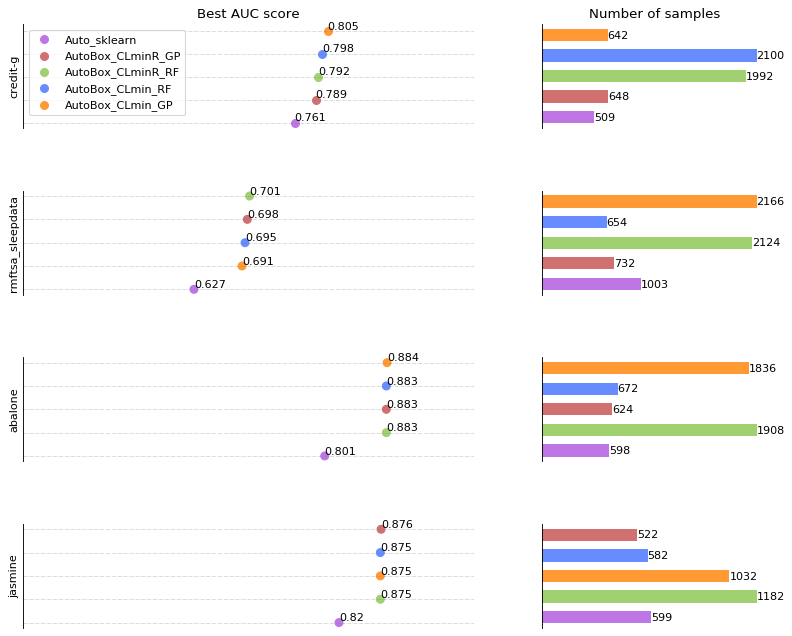

In [28]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 10),dpi = 80 )
gs = gridspec.GridSpec(4, 2,
                       width_ratios=[2, 1],
                       height_ratios=[1,1,1,1]
                       )
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax6 = plt.subplot(gs[5])
ax7 = plt.subplot(gs[6])
ax8 = plt.subplot(gs[7])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(True)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(True)

ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.spines['bottom'].set_visible(False)
ax7.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.spines['bottom'].set_visible(False)


colors = ["#BD76E4",#autosklearn,
          "#D07070",#PAGP
          "#A0D070",#PARF
          "#668cff",#RMGP
          "#ff9933"#RMRF
         ]

for s,color in zip(summary.strategy,colors):
    i = np.where(summary.strategy==s)[0][0]
    ax1.scatter(summary.best_score[i],summary.strategy[i], s=50,c=color,label=s)
ax1.legend(loc=2)
for i, txt in enumerate(summary.best_score):
    ax1.annotate(txt, (summary.best_score[i], summary.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax1.grid(linestyle='--', alpha=0.7 ,axis='y')
ax1.set_ylabel("credit-g")
b = ax2.barh(np.arange(len(summary.strategy)),summary.iteration,color=colors,align='center',height=0.6)
for rect in b:
    w = rect.get_width()
    ax2.text(w, rect.get_y()+rect.get_height()/2, '%d' %
            int(w), ha='left', va='center')
ax2.grid(linestyle='--', alpha=0.5,axis='x')
ax1.set_title("Best AUC score")
ax2.set_title("Number of samples")

colors1 = ["#BD76E4",#autosklearn,
          "#A0D070",#PARF
        "#D07070",#PAGP
           "#668cff",#RMGP
           "#ff9933",#RMRF
    ]#RF
ax5.scatter(summary6.best_score,summary6.strategy, s=50,color=colors1)
for i, txt in enumerate(summary6.best_score):
    ax5.annotate(txt, (summary6.best_score[i], summary6.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax5.grid(linestyle='--', alpha=0.7 ,axis='y')
ax5.set_ylabel("abalone")
b = ax6.barh(np.arange(len(summary6.strategy)),summary6.iteration,color=colors1,align='center',height=0.6)
for rect in b:
    w = rect.get_width()
    ax6.text(w, rect.get_y()+rect.get_height()/2, '%d' %
            int(w), ha='left', va='center')
ax6.grid(linestyle='--', alpha=0.5)

colors2 = ["#BD76E4",#autosklearn,
          "#A0D070",#PARF
           "#ff9933",#RMRF
          "#668cff",#RMGP
          "#D07070",#PAGP  
    ]#RF
ax7.scatter(summary7.best_score,summary7.strategy, s=50,color=colors2)
for i, txt in enumerate(summary7.best_score):
    ax7.annotate(txt, (summary7.best_score[i], summary7.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax7.grid(linestyle='--', alpha=0.7 ,axis='y')
ax7.set_ylabel("jasmine")
b = ax8.barh(np.arange(len(summary7.strategy)),summary7.iteration,color=colors2,align='center',height=0.6)
for rect in b:
    w = rect.get_width()
    ax8.text(w, rect.get_y()+rect.get_height()/2, '%d' %
            int(w), ha='left', va='center')
ax8.grid(linestyle='--', alpha=0.5)

colors3 = [ "#BD76E4",#autosklearn,
            "#ff9933",#RMRF
            "#668cff",#RMGP
            "#D07070",#PAGP
           "#A0D070",#PARF
    ]#RF
ax3.scatter(summary5.best_score,summary5.strategy, s=50,color=colors3)
for i, txt in enumerate(summary5.best_score):
    ax3.annotate(txt, (summary5.best_score[i], summary5.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax3.grid(linestyle='--', alpha=0.7 ,axis='y')
ax3.set_ylabel("rmftsa_sleepdata")
b = ax4.barh(np.arange(len(summary5.strategy)),summary5.iteration,color=colors,align='center',height=0.6)
for rect in b:
    w = rect.get_width()
    ax4.text(w, rect.get_y()+rect.get_height()/2, '%d' %
            int(w), ha='left', va='center')
ax4.grid(linestyle='--', alpha=0.5)

ax1.set_xlim(0.4,1)
ax3.set_xlim(0.4,1)
ax5.set_xlim(0.4,1)
ax7.set_xlim(0.4,1)

ax1.set_xticks([])
ax5.set_xticks([])
ax3.set_xticks([])
ax2.set_xticks([])
ax4.set_xticks([])
ax6.set_xticks([])
ax8.set_xticks([])
ax7.set_xticks([])

ax1.set_yticks([])
ax5.set_yticks([])
ax3.set_yticks([])
ax7.set_yticks([])
ax2.set_yticks([])
ax4.set_yticks([])
ax6.set_yticks([])
ax8.set_yticks([])


ax1.hlines(y=summary.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax5.hlines(y=summary5.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax3.hlines(y=summary5.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax7.hlines(y=summary5.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')


plt.subplots_adjust(hspace=0.6)
plt.savefig("autosklearn-balanced")
plt.show()

# Unbalanced

## dataset_44_spambase

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary
dataset="dataset_44_spambase"
BO_results4 = load_result(dataset+"_Onehour_parallel_BO_new.json")
bo_gp4 = transfer_GP_to_table(BO_results4)
bo_rf4 = transfer_RF_to_table(BO_results4)

BO_rm_results4 = load_result(dataset+'_Onehour_parallel_BO_RM_new.json')
bo_rm_gp4 = transfer_GP_to_table(BO_rm_results4)
bo_rm_rf4 = transfer_RF_to_table(BO_rm_results4)

automl = load_result(dataset+"_Onehour_autosklearn_new.json")
automl_result4 = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result4['mean_score']=automl["mean_test_score"]

# #save_pic= False
# import os
# #plot_convergence(test_rm, 'Randomsearch')
# fig = plt.figure(figsize=(15, 6))
# ax = fig.add_subplot(1,1,1)
# #ax1 = fig.add_subplot(1,2,2)
# plot_convergence(bo_gp4, 'AutoBox_GP',color = 'orange',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rf4, 'AutoBox_RF',color = 'g',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(automl_result4, 'Auto Sklearn',color = 'r',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(bo_rm_gp4, 'AutoBox_GP',color = 'purple',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rm_rf4, 'AutoBox_RF',color = 'deeppink',ax=ax,ls='--',title='Convergence Plot')

bo_gp_clock_time4 = BO_results4["GP"]['Time_cost']
bo_rf_clock_time4 = BO_results4["RF"]['Time_cost']
bo_gp_best_score4 = round(BO_results4["GP"]['best_score'], 3)
bo_rf_best_score4 = round(BO_results4["RF"]['best_score'], 3)

automl_best_score4 = round(max(automl["mean_test_score"]),3)
automl_clock_time4 =  round(3600, 3)


bo_gprm_best_score4=round(BO_rm_results4["GP"]['best_score'], 3)
bo_rfrm_best_score4=round(BO_rm_results4["RF"]['best_score'], 3)
bo_gprm_clock_time4 = round(BO_rm_results4["GP"]['Time_cost'], 1)
bo_rfrm_clock_time4 = round(BO_rm_results4["RF"]['Time_cost'], 1)

summary9 = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary9["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary9["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary9["best_score"]=[bo_gprm_best_score4,bo_rfrm_best_score4,bo_gp_best_score4,bo_rf_best_score4,automl_best_score4]
summary9["clock_time"]=[bo_gprm_clock_time4,bo_rfrm_clock_time4,bo_gp_clock_time4,bo_rf_clock_time4,automl_clock_time4]
summary9["iteration"]=[len(BO_rm_results4["GP"]["all_cv_results"]),len(BO_rm_results4["RF"]["all_cv_results"]),len(BO_results4["GP"]["all_cv_results"]),len(BO_results4["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary9 = summary9.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary9



,dataset,strategy,best_score,clock_time,iteration
0,dataset_44_spambase,Auto_sklearn,0.951,3600.0,699
1,dataset_44_spambase,AutoBox_CLmin_RF,0.987,3553.0,1020
2,dataset_44_spambase,AutoBox_CLminR_GP,0.987,3523.0,594
3,dataset_44_spambase,AutoBox_CLmin_GP,0.987,3511.0,516
4,dataset_44_spambase,AutoBox_CLminR_RF,0.988,3569.0,1134


## cpu_small

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary
dataset="cpu_small"
BO_results4 = load_result(dataset+"_Onehour_parallel_BO_new.json")
bo_gp4 = transfer_GP_to_table(BO_results4)
bo_rf4 = transfer_RF_to_table(BO_results4)

BO_rm_results4 = load_result(dataset+'_Onehour_parallel_BO_RM_new.json')
bo_rm_gp4 = transfer_GP_to_table(BO_rm_results4)
bo_rm_rf4 = transfer_RF_to_table(BO_rm_results4)

automl = load_result(dataset+"_Onehour_autosklearn_new.json")
automl_result4 = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result4['mean_score']=automl["mean_test_score"]

# #save_pic= False
# import os
# #plot_convergence(test_rm, 'Randomsearch')
# fig = plt.figure(figsize=(15, 6))
# ax = fig.add_subplot(1,1,1)
# #ax1 = fig.add_subplot(1,2,2)
# plot_convergence(bo_gp4, 'AutoBox_GP',color = 'orange',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rf4, 'AutoBox_RF',color = 'g',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(automl_result4, 'Auto Sklearn',color = 'r',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(bo_rm_gp4, 'AutoBox_GP',color = 'purple',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rm_rf4, 'AutoBox_RF',color = 'deeppink',ax=ax,ls='--',title='Convergence Plot')

bo_gp_clock_time4 = BO_results4["GP"]['Time_cost']
bo_rf_clock_time4 = BO_results4["RF"]['Time_cost']
bo_gp_best_score4 = round(BO_results4["GP"]['best_score'], 3)
bo_rf_best_score4 = round(BO_results4["RF"]['best_score'], 3)

automl_best_score4 = round(max(automl["mean_test_score"]),3)
automl_clock_time4 =  round(3600, 3)


bo_gprm_best_score4=round(BO_rm_results4["GP"]['best_score'], 3)
bo_rfrm_best_score4=round(BO_rm_results4["RF"]['best_score'], 3)
bo_gprm_clock_time4 = round(BO_rm_results4["GP"]['Time_cost'], 1)
bo_rfrm_clock_time4 = round(BO_rm_results4["RF"]['Time_cost'], 1)

summary8 = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary8["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary8["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary8["best_score"]=[bo_gprm_best_score4,bo_rfrm_best_score4,bo_gp_best_score4,bo_rf_best_score4,automl_best_score4]
summary8["clock_time"]=[bo_gprm_clock_time4,bo_rfrm_clock_time4,bo_gp_clock_time4,bo_rf_clock_time4,automl_clock_time4]
summary8["iteration"]=[len(BO_rm_results4["GP"]["all_cv_results"]),len(BO_rm_results4["RF"]["all_cv_results"]),len(BO_results4["GP"]["all_cv_results"]),len(BO_results4["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary8 = summary8.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary8



,dataset,strategy,best_score,clock_time,iteration
0,cpu_small,Auto_sklearn,0.924,3600.0,352
1,cpu_small,AutoBox_CLmin_GP,0.979,3569.0,582
2,cpu_small,AutoBox_CLminR_RF,0.979,3561.0,1158
3,cpu_small,AutoBox_CLmin_RF,0.979,3551.0,1002
4,cpu_small,AutoBox_CLminR_GP,0.979,3544.0,624


## mc1

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary
dataset="mc1"
BO_results4 = load_result("mc1_Onehour_parallel_BO.json")
bo_gp4 = transfer_GP_to_table(BO_results4)
bo_rf4 = transfer_RF_to_table(BO_results4)

BO_rm_results4 = load_result(dataset+'_Onehour_parallel_BO_RM.json')
bo_rm_gp4 = transfer_GP_to_table(BO_rm_results4)
bo_rm_rf4 = transfer_RF_to_table(BO_rm_results4)

automl = load_result("mc1_Onehour_autosklearn.json")
automl_result4 = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result4['mean_score']=automl["mean_test_score"]

# #save_pic= False
# import os
# #plot_convergence(test_rm, 'Randomsearch')
# fig = plt.figure(figsize=(15, 6))
# ax = fig.add_subplot(1,1,1)
# #ax1 = fig.add_subplot(1,2,2)
# plot_convergence(bo_gp4, 'AutoBox_GP',color = 'orange',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rf4, 'AutoBox_RF',color = 'g',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(automl_result4, 'Auto Sklearn',color = 'r',ax=ax,ls='--',title='Convergence Plot')
# plot_convergence(bo_rm_gp4, 'AutoBox_GP',color = 'purple',ax=ax,title='Convergence Plot')
# plot_convergence(bo_rm_rf4, 'AutoBox_RF',color = 'deeppink',ax=ax,ls='--',title='Convergence Plot')



In [6]:
bo_gp_clock_time4 = BO_results4["GP"]['Time_cost']
bo_rf_clock_time4 = BO_results4["RF"]['Time_cost']
bo_gp_best_score4 = round(BO_results4["GP"]['best_score'], 3)
bo_rf_best_score4 = round(BO_results4["RF"]['best_score'], 3)

automl_best_score4 = round(max(automl["mean_test_score"]),3)
automl_clock_time4 =  round(3600, 3)

BO_rm_results4 = load_result(dataset+'_Onehour_parallel_BO_RM.json')
bo_rm_gp4 = transfer_GP_to_table(BO_rm_results4)
bo_rm_rf4 = transfer_RF_to_table(BO_rm_results4)

bo_gprm_best_score4=round(BO_rm_results4["GP"]['best_score'], 3)
bo_rfrm_best_score4=round(BO_rm_results4["RF"]['best_score'], 3)
bo_gprm_clock_time4 = round(BO_rm_results4["GP"]['Time_cost'], 1)
bo_rfrm_clock_time4 = round(BO_rm_results4["RF"]['Time_cost'], 1)

summary4 = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary4["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary4["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary4["best_score"]=[bo_gprm_best_score4,bo_rfrm_best_score4,bo_gp_best_score4,bo_rf_best_score4,automl_best_score4]
summary4["clock_time"]=[bo_gprm_clock_time4,bo_rfrm_clock_time4,bo_gp_clock_time4,bo_rf_clock_time4,automl_clock_time4]
summary4["iteration"]=[len(BO_rm_results4["GP"]["all_cv_results"]),len(BO_rm_results4["RF"]["all_cv_results"]),len(BO_results4["GP"]["all_cv_results"]),len(BO_results4["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary4 = summary4.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary4



,dataset,strategy,best_score,clock_time,iteration
0,mc1,AutoBox_CLmin_GP,0.867,3590.0,546
1,mc1,AutoBox_CLminR_GP,0.869,2763.0,468
2,mc1,AutoBox_CLmin_RF,0.879,3566.0,1524
3,mc1,AutoBox_CLminR_RF,0.881,3572.0,1638
4,mc1,Auto_sklearn,0.977,3600.0,391


## pc 2

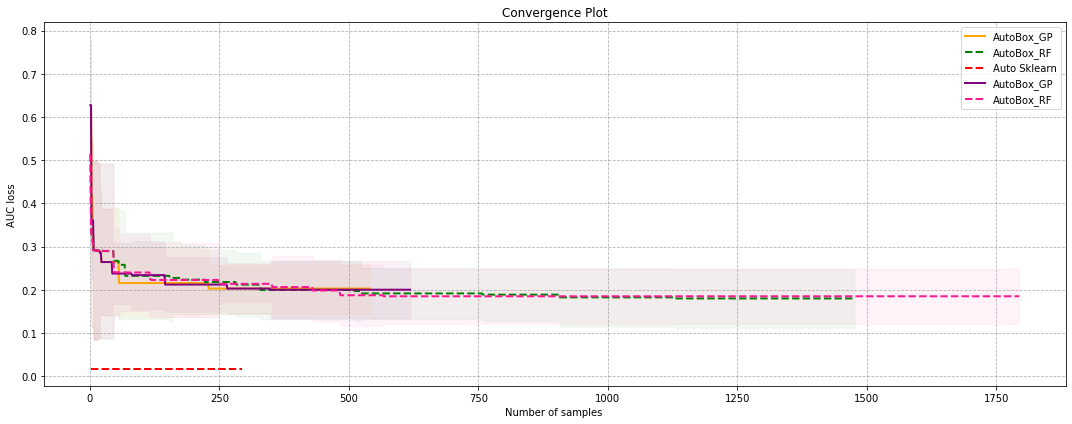

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary
dataset="pc2"
BO_results3 = load_result("pc2_Onehour_parallel_BO.json")
bo_gp3 = transfer_GP_to_table(BO_results3)
bo_rf3 = transfer_RF_to_table(BO_results3)

automl = load_result("pc2_Onehour_autosklearn.json")
automl_result3 = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result3['mean_score']=automl["mean_test_score"]

BO_rm_results3 = load_result(dataset+'_Onehour_parallel_BO_RM.json')
bo_rm_gp3 = transfer_GP_to_table(BO_rm_results3)
bo_rm_rf3 = transfer_RF_to_table(BO_rm_results3)

#save_pic= False
import os
#plot_convergence(test_rm, 'Randomsearch')
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,1,1)
#ax1 = fig.add_subplot(1,2,2)
plot_convergence(bo_gp3, 'AutoBox_GP',color = 'orange',ax=ax,title='Convergence Plot')
plot_convergence(bo_rf3, 'AutoBox_RF',color = 'g',ax=ax,ls='--',title='Convergence Plot')
plot_convergence(automl_result3, 'Auto Sklearn',color = 'r',ax=ax,ls='--',title='Convergence Plot')
plot_convergence(bo_rm_gp3, 'AutoBox_GP',color = 'purple',ax=ax,title='Convergence Plot')
plot_convergence(bo_rm_rf3, 'AutoBox_RF',color = 'deeppink',ax=ax,ls='--',title='Convergence Plot')


In [8]:
bo_gp_clock_time3 = BO_results3["GP"]['Time_cost']
bo_rf_clock_time3 = BO_results3["RF"]['Time_cost']
bo_gp_best_score3 = round(BO_results3["GP"]['best_score'], 3)
bo_rf_best_score3 = round(BO_results3["RF"]['best_score'], 3)

automl_best_score3 = round(max(automl["mean_test_score"]),3)
automl_clock_time3 =  round(3600, 3)

bo_gprm_best_score3 = round(BO_rm_results3["GP"]['best_score'], 3)
bo_rfrm_best_score3 = round(BO_rm_results3["RF"]['best_score'], 3)
bo_gprm_clock_time3 = round(BO_rm_results3["GP"]['Time_cost'], 1)
bo_rfrm_clock_time3 = round(BO_rm_results3["RF"]['Time_cost'], 1)

summary3 = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary3["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary3["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary3["best_score"]=[bo_gprm_best_score3,bo_rfrm_best_score3,bo_gp_best_score3,bo_rf_best_score3,automl_best_score3]
summary3["clock_time"]=[bo_gprm_clock_time3,bo_rfrm_clock_time3,bo_gp_clock_time3,bo_rf_clock_time3,automl_clock_time3]
summary3["iteration"]=[len(BO_rm_results3["GP"]["all_cv_results"]),len(BO_rm_results3["RF"]["all_cv_results"]),len(BO_results3["GP"]["all_cv_results"]),len(BO_results3["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary3 = summary3.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary3



,dataset,strategy,best_score,clock_time,iteration
0,pc2,AutoBox_CLmin_GP,0.797,3575.0,540
1,pc2,AutoBox_CLminR_GP,0.800,3521.0,618
2,pc2,AutoBox_CLminR_RF,0.815,3578.0,1794
3,pc2,AutoBox_CLmin_RF,0.820,3578.0,1476
4,pc2,Auto_sklearn,0.984,3600.0,293


## kc1

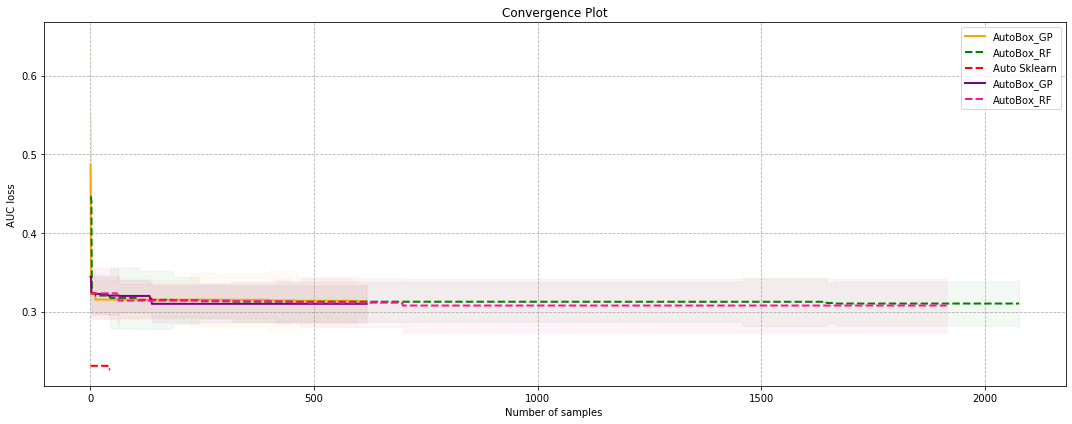

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary
dataset="kc1"
BO_results2 = load_result("kc1_Onehour_parallel_BO.json")
bo_gp2 = transfer_GP_to_table(BO_results2)
bo_rf2 = transfer_RF_to_table(BO_results2)

automl = load_result("kc1_Onehour_autosklearn.json")
automl_result2 = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result2['mean_score']=automl["mean_test_score"]

BO_rm_results2 = load_result(dataset+'_Onehour_parallel_BO_RM.json')
bo_rm_gp2 = transfer_GP_to_table(BO_rm_results2)
bo_rm_rf2 = transfer_RF_to_table(BO_rm_results2)

#save_pic= False
import os
#plot_convergence(test_rm, 'Randomsearch')
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,1,1)
#ax1 = fig.add_subplot(1,2,2)
plot_convergence(bo_gp2, 'AutoBox_GP',color = 'orange',ax=ax,title='Convergence Plot')
plot_convergence(bo_rf2, 'AutoBox_RF',color = 'g',ax=ax,ls='--',title='Convergence Plot')
plot_convergence(automl_result2, 'Auto Sklearn',color = 'r',ax=ax,ls='--',title='Convergence Plot')
plot_convergence(bo_rm_gp2, 'AutoBox_GP',color = 'purple',ax=ax,title='Convergence Plot')
plot_convergence(bo_rm_rf2, 'AutoBox_RF',color = 'deeppink',ax=ax,ls='--',title='Convergence Plot')


In [10]:
bo_gp_clock_time2 = BO_results2["GP"]['Time_cost']
bo_rf_clock_time2 = BO_results2["RF"]['Time_cost']
bo_gp_best_score2 = round(BO_results2["GP"]['best_score'], 3)
bo_rf_best_score2 = round(BO_results2["RF"]['best_score'], 3)

automl_best_score2 = round(max(automl["mean_test_score"]),3)
automl_clock_time2 =  round(3600, 3)
bo_gprm_best_score2 = round(BO_rm_results2["GP"]['best_score'], 3)
bo_rfrm_best_score2 = round(BO_rm_results2["RF"]['best_score'], 3)
bo_gprm_clock_time2 = round(BO_rm_results2["GP"]['Time_cost'], 1)
bo_rfrm_clock_time2 = round(BO_rm_results2["RF"]['Time_cost'], 1)

summary2 = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary2["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary2["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary2["best_score"]=[bo_gprm_best_score2,bo_rfrm_best_score2,bo_gp_best_score2,bo_rf_best_score2,automl_best_score2]
summary2["clock_time"]=[bo_gprm_clock_time2,bo_rfrm_clock_time2,bo_gp_clock_time2,bo_rf_clock_time2,automl_clock_time2]
summary2["iteration"]=[len(BO_rm_results2["GP"]["all_cv_results"]),len(BO_rm_results2["RF"]["all_cv_results"]),len(BO_results2["GP"]["all_cv_results"]),len(BO_results2["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary2 = summary2.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary2



,dataset,strategy,best_score,clock_time,iteration
0,kc1,AutoBox_CLmin_GP,0.687,3272.0,618
1,kc1,AutoBox_CLmin_RF,0.690,3598.0,2076
2,kc1,AutoBox_CLminR_GP,0.690,3588.0,618
3,kc1,AutoBox_CLminR_RF,0.692,3587.0,1914
4,kc1,Auto_sklearn,0.773,3600.0,45


## jm1

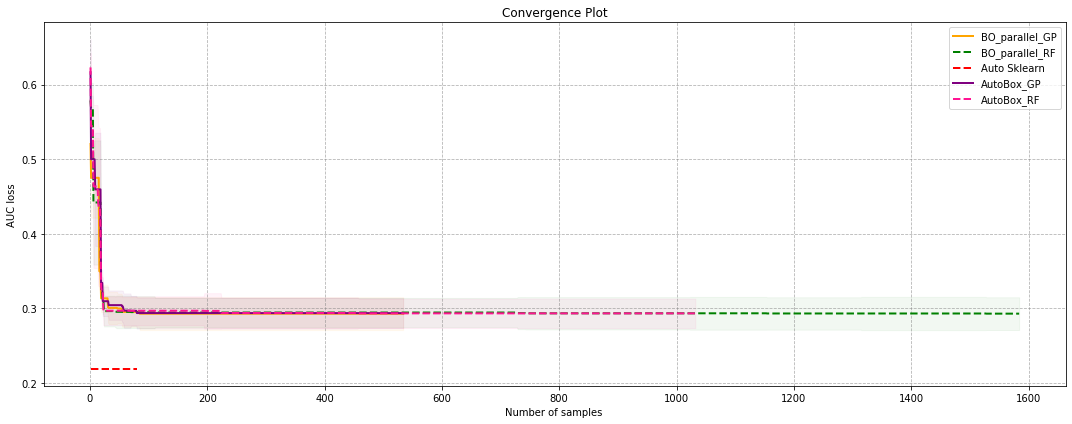

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from plot import transfer_GP_to_table,transfer_RF_to_table,plot_line,plot_bar,plot_convergence
from util import dump_result,load_result,result_summary
dataset="jm1"
BO_results1 = load_result("jm1_Onehour_parallel_BO.json")
bo_gp1 = transfer_GP_to_table(BO_results1)
bo_rf1 = transfer_RF_to_table(BO_results1)

automl=  load_result("jm1_Onehour_autosklearn.json")
automl_result1 = pd.DataFrame(columns = ["model","mean_score",'std_score'])
automl_result1['mean_score']=automl["mean_test_score"]

BO_rm_results1 = load_result(dataset+'_Onehour_parallel_BO_RM.json')
bo_rm_gp1 = transfer_GP_to_table(BO_rm_results1)
bo_rm_rf1 = transfer_RF_to_table(BO_rm_results1)
#save_pic= False
import os
#plot_convergence(test_rm, 'Randomsearch')
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,1,1)
#ax1 = fig.add_subplot(1,2,2)
plot_convergence(bo_gp1, 'BO_parallel_GP',color = 'orange',ax=ax,title='Convergence Plot')
plot_convergence(bo_rf1, 'BO_parallel_RF',color = 'g',ax=ax,ls='--',title='Convergence Plot')
plot_convergence(automl_result1, 'Auto Sklearn',color = 'r',ax=ax,ls='--',title='Convergence Plot')
plot_convergence(bo_rm_gp1, 'AutoBox_GP',color = 'purple',ax=ax,title='Convergence Plot')
plot_convergence(bo_rm_rf1, 'AutoBox_RF',color = 'deeppink',ax=ax,ls='--',title='Convergence Plot')


In [12]:
bo_gp_clock_time1 = BO_results1["GP"]['Time_cost']
bo_rf_clock_time1 = BO_results1["RF"]['Time_cost']
bo_gp_best_score1 = round(BO_results1["GP"]['best_score'], 3)
bo_rf_best_score1 = round(BO_results1["RF"]['best_score'], 3)

automl_best_score1 = round(max(automl["mean_test_score"]),3)
automl_clock_time1 =  round(3600, 3)

bo_gprm_best_score1 = round(BO_rm_results1["GP"]['best_score'], 3)
bo_rfrm_best_score1 = round(BO_rm_results1["RF"]['best_score'], 3)
bo_gprm_clock_time1 = round(BO_rm_results1["GP"]['Time_cost'], 1)
bo_rfrm_clock_time1 = round(BO_rm_results1["RF"]['Time_cost'], 1)

summary1 = pd.DataFrame(columns = ["dataset","strategy","best_score","clock_time","iteration"])
summary1["dataset"]=[dataset,dataset,dataset,dataset,dataset]
summary1["strategy"]=['AutoBox_CLminR_GP','AutoBox_CLminR_RF','AutoBox_CLmin_GP','AutoBox_CLmin_RF',"Auto_sklearn"]
summary1["best_score"]=[bo_gprm_best_score1,bo_rfrm_best_score1,bo_gp_best_score1,bo_rf_best_score1,automl_best_score1]
summary1["clock_time"]=[bo_gprm_clock_time1,bo_rfrm_clock_time1,bo_gp_clock_time1,bo_rf_clock_time1,automl_clock_time1]
summary1["iteration"]=[len(BO_rm_results1["GP"]["all_cv_results"]),len(BO_rm_results1["RF"]["all_cv_results"]),len(BO_results1["GP"]["all_cv_results"]),len(BO_results1["RF"]["all_cv_results"]),len(automl["mean_test_score"])]
summary1 = summary1.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)
summary1



,dataset,strategy,best_score,clock_time,iteration
0,jm1,AutoBox_CLminR_GP,0.706,3268.0,534
1,jm1,AutoBox_CLmin_RF,0.707,3558.0,1584
2,jm1,AutoBox_CLminR_RF,0.707,3541.0,1032
3,jm1,AutoBox_CLmin_GP,0.707,3499.0,534
4,jm1,Auto_sklearn,0.782,3600.0,81


# summary

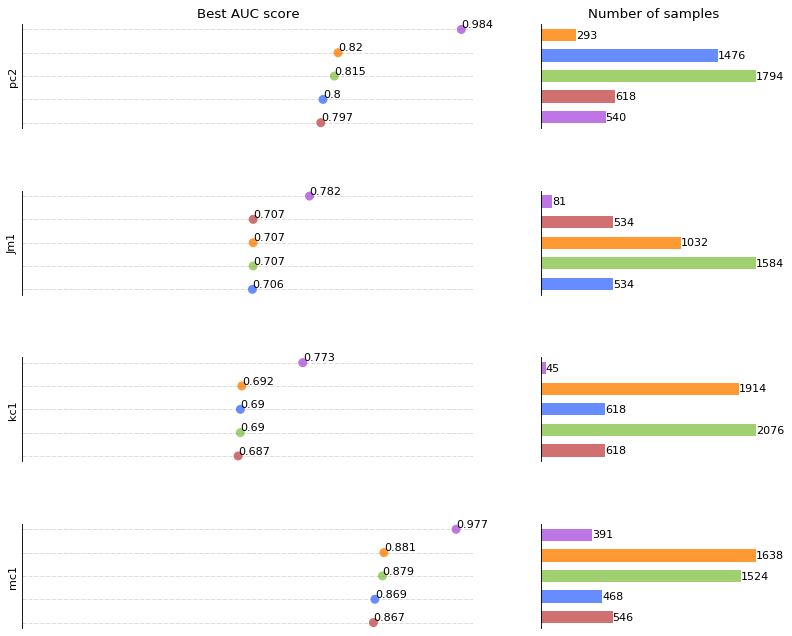

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 10),dpi = 80 )
gs = gridspec.GridSpec(4, 2,
                       width_ratios=[2, 1],
                       height_ratios=[1,1,1,1]
                       )
# ax1 = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[0])
ax4 = plt.subplot(gs[1])
ax5 = plt.subplot(gs[2])
ax6 = plt.subplot(gs[3])
ax7 = plt.subplot(gs[4])
ax8 = plt.subplot(gs[5])
ax9 = plt.subplot(gs[6])
ax10 = plt.subplot(gs[7])


ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.spines['bottom'].set_visible(False)
ax9.spines['left'].set_visible(True)
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
# ax1.spines['left'].set_visible(True)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(True)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(True)

ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.spines['bottom'].set_visible(False)
ax7.spines['left'].set_visible(True)
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.spines['bottom'].set_visible(False)
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.spines['bottom'].set_visible(False)

# colors = ["#BD76E4",#autosklearn,
#           "#D07070",#PAGP
#           "#A0D070",#PARF
#           "#668cff",#RMGP
#           "#ff9933"#RMRF
#          ]

# for s,color in zip(summary.strategy,colors):
#     i = np.where(summary.strategy==s)[0][0]
#     ax1.scatter(summary.best_score[i],summary.strategy[i], s=50,c=color,label=s)
# ax1.legend(loc=2)
# for i, txt in enumerate(summary.best_score):
#     ax1.annotate(txt, (summary.best_score[i], summary.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
# ax1.grid(linestyle='--', alpha=0.7 ,axis='y')
# ax1.set_ylabel("credit-g")
# b = ax2.barh(np.arange(len(summary.strategy)),summary.iteration,color=colors,align='center',height=0.6)
# for rect in b:
#     w = rect.get_width()
#     ax2.text(w, rect.get_y()+rect.get_height()/2, '%d' %
#             int(w), ha='left', va='center')
# ax2.grid(linestyle='--', alpha=0.5,axis='x')

colors1 = [
        "#668cff",#RMGP
          "#A0D070",#PARF
          "#ff9933",#RMRF
        "#D07070",#PAGP
         "#BD76E4",#autosklearn,
    ]#RF
ax5.scatter(summary1.best_score,summary1.strategy, s=50,color=colors1)
for i, txt in enumerate(summary1.best_score):
    ax5.annotate(txt, (summary1.best_score[i], summary1.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax5.grid(linestyle='--', alpha=0.7 ,axis='y')
ax5.set_ylabel("Jm1")
b = ax6.barh(np.arange(len(summary1.strategy)),summary1.iteration,color=colors1,align='center',height=0.6)
for rect in b:
    w = rect.get_width()
    ax6.text(w, rect.get_y()+rect.get_height()/2, '%d' %
            int(w), ha='left', va='center')
ax6.grid(linestyle='--', alpha=0.5)

colors2 = [
          "#D07070",#PAGP
          "#A0D070",#PARF
          "#668cff",#RMGP
          "#ff9933",#RMRF
          "#BD76E4",#autosklearn,
    ]#RF
ax7.scatter(summary2.best_score,summary2.strategy, s=50,color=colors2)
for i, txt in enumerate(summary2.best_score):
    ax7.annotate(txt, (summary2.best_score[i], summary2.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax7.grid(linestyle='--', alpha=0.7 ,axis='y')
ax7.set_ylabel("kc1")
b = ax8.barh(np.arange(len(summary2.strategy)),summary2.iteration,color=colors2,align='center',height=0.6)
for rect in b:
    w = rect.get_width()
    ax8.text(w, rect.get_y()+rect.get_height()/2, '%d' %
            int(w), ha='left', va='center')
ax8.grid(linestyle='--', alpha=0.5)

colors3 = [
          "#D07070",#PAGP
    "#668cff",#RMGP
          "#A0D070",#PARF
          "#ff9933",#RMRF
          "#BD76E4",#autosklearn,
    ]#RF
ax3.scatter(summary3.best_score,summary3.strategy, s=50,color=colors3)
for i, txt in enumerate(summary3.best_score):
    ax3.annotate(txt, (summary3.best_score[i], summary3.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax3.grid(linestyle='--', alpha=0.7 ,axis='y')
ax3.set_ylabel("pc2")
b = ax4.barh(np.arange(len(summary3.strategy)),summary3.iteration,color=colors,align='center',height=0.6)
for rect in b:
    w = rect.get_width()
    ax4.text(w, rect.get_y()+rect.get_height()/2, '%d' %
            int(w), ha='left', va='center')
ax4.grid(linestyle='--', alpha=0.5)
ax3.set_title("Best AUC score")
ax4.set_title("Number of samples")


colors4 = [
          "#D07070",#PAGP
          "#668cff",#RMGP
          "#A0D070",#PARF
          "#ff9933",#RMRF
          "#BD76E4",#autosklearn,
    ]#RF
ax9.scatter(summary4.best_score,summary4.strategy, s=50,color=colors4)
for i, txt in enumerate(summary4.best_score):
    ax9.annotate(txt, (summary4.best_score[i], summary4.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax9.grid(linestyle='--', alpha=0.7 ,axis='y')
ax9.set_ylabel("mc1")
b = ax10.barh(np.arange(len(summary4.strategy)),summary4.iteration,color=colors4,align='center',height=0.6)
for rect in b:
    w = rect.get_width()
    ax10.text(w, rect.get_y()+rect.get_height()/2, '%d' %
            int(w), ha='left', va='center')
ax10.grid(linestyle='--', alpha=0.5)

ax9.set_xlim(0.4,1)
# ax1.set_xlim(0.4,1)
ax3.set_xlim(0.4,1)
ax5.set_xlim(0.4,1)
ax7.set_xlim(0.4,1)

# ax1.set_xticks([])
ax5.set_xticks([])
ax3.set_xticks([])
# ax2.set_xticks([])
ax4.set_xticks([])
ax6.set_xticks([])
ax8.set_xticks([])
ax7.set_xticks([])
ax9.set_xticks([])
ax10.set_xticks([])
ax9.set_yticks([])
# ax1.set_yticks([])
ax5.set_yticks([])
ax3.set_yticks([])
ax7.set_yticks([])
# ax2.set_yticks([])
ax4.set_yticks([])
ax6.set_yticks([])
ax8.set_yticks([])
ax10.set_yticks([])

ax9.hlines(y=summary.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
# ax1.hlines(y=summary1.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax5.hlines(y=summary2.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax3.hlines(y=summary3.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax7.hlines(y=summary3.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')


plt.subplots_adjust(hspace=0.6)
plt.savefig("autosklearn")
plt.show()

# summary2

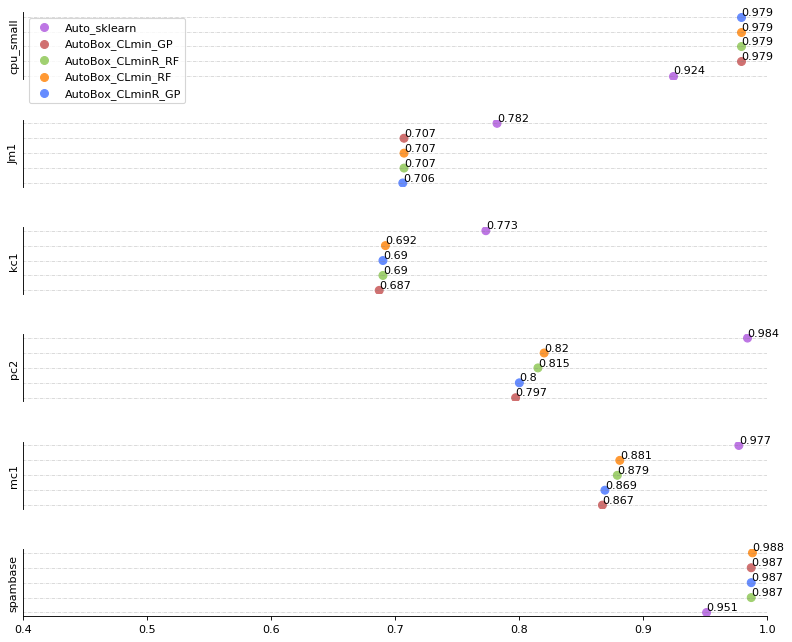

In [19]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

fig = plt.figure(figsize=(12, 10),dpi = 80 )
ax = fig.add_subplot(6,1,1)
ax1 = fig.add_subplot(6,1,2)
ax2 = fig.add_subplot(6,1,3)
ax3 = fig.add_subplot(6,1,4)
ax4 = fig.add_subplot(6,1,5)
ax5 = fig.add_subplot(6,1,6)


colors = ["#BD76E4",#autosklearn,
          "#D07070",#PAGP
          "#A0D070",#PARF
          "#ff9933",#RMRF
          "#668cff",#RMGP
         ]

for s,color in zip(summary8.strategy,colors):
    i = np.where(summary8.strategy==s)[0][0]
    ax.scatter(summary8.best_score[i],summary8.strategy[i], s=50,c=color,label=s)
ax.legend(loc=2)
for i, txt in enumerate(summary8.best_score):
    ax.annotate(txt, (summary8.best_score[i], summary8.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax.grid(linestyle='--', alpha=0.7 ,axis='y')
ax.set_ylabel("cpu_small")

colors1 = [
        "#668cff",#RMGP
          "#A0D070",#PARF
          "#ff9933",#RMRF
        "#D07070",#PAGP
         "#BD76E4",#autosklearn,
    ]#RF
ax1.scatter(summary1.best_score,summary1.strategy, s=50,color=colors1)
for i, txt in enumerate(summary1.best_score):
    ax1.annotate(txt, (summary1.best_score[i], summary1.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax1.grid(linestyle='--', alpha=0.7 ,axis='y')
ax1.set_ylabel("Jm1")


colors2 = [
          "#D07070",#PAGP
          "#A0D070",#PARF
          "#668cff",#RMGP
          "#ff9933",#RMRF
          "#BD76E4",#autosklearn,
    ]#RF
ax2.scatter(summary2.best_score,summary2.strategy, s=50,color=colors2)
for i, txt in enumerate(summary2.best_score):
    ax2.annotate(txt, (summary2.best_score[i], summary2.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax2.grid(linestyle='--', alpha=0.7 ,axis='y')
ax2.set_ylabel("kc1")

colors3 = [
          "#D07070",#PAGP
    "#668cff",#RMGP
          "#A0D070",#PARF
          "#ff9933",#RMRF
          "#BD76E4",#autosklearn,
    ]#RF
ax3.scatter(summary3.best_score,summary3.strategy, s=50,color=colors3)
for i, txt in enumerate(summary3.best_score):
    ax3.annotate(txt, (summary3.best_score[i], summary3.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax3.grid(linestyle='--', alpha=0.7 ,axis='y')
ax3.set_ylabel("pc2")

colors4 = [
          "#D07070",#PAGP
          "#668cff",#RMGP
          "#A0D070",#PARF
          "#ff9933",#RMRF
          "#BD76E4",#autosklearn,
    ]#RF
ax4.scatter(summary4.best_score,summary4.strategy, s=50,color=colors4)
for i, txt in enumerate(summary4.best_score):
    ax4.annotate(txt, (summary4.best_score[i], summary4.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax4.grid(linestyle='--', alpha=0.7 ,axis='y')
ax4.set_ylabel("mc1")

colors5 = [
        "#BD76E4",#autosklearn,
          "#A0D070",#PARF
          "#668cff",#RMGP
         "#D07070",#PAGP
          "#ff9933",#RMRF
          
    ]#RF
ax5.scatter(summary9.best_score,summary9.strategy, s=50,color=colors5)
for i, txt in enumerate(summary9.best_score):
    ax5.annotate(txt, (summary9.best_score[i], summary9.strategy[i]), horizontalalignment='left',verticalalignment='bottom')
ax5.grid(linestyle='--', alpha=0.7 ,axis='y')
ax5.set_ylabel("spambase")

ax.set_xlim(0.4,1)
ax1.set_xlim(0.4,1)
ax2.set_xlim(0.4,1)
ax3.set_xlim(0.4,1)
ax4.set_xlim(0.4,1)
ax5.set_xlim(0.4,1)

ax.set_xticks([])
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])

ax.set_yticks([])
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax5.set_yticks([])

ax.hlines(y=summary8.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax1.hlines(y=summary1.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax2.hlines(y=summary2.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax3.hlines(y=summary3.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax4.hlines(y=summary3.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')
ax5.hlines(y=summary9.index, xmin=0, xmax=1, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(True)

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(True)

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(True)

plt.subplots_adjust(hspace=0.6)
#
#plt.tight_layout()

# file_name= 'Seed_summary_'+dataset+'_'+str(niteration)
# file_path =os.path.join(DIRS["pic"],dataset)
# if save_pic is True:
#     if not (os.path.exists(file_path)):
#         os.makedirs(file_path)
#     elif (os.path.exists(file_path)):
#         pass
#     plt.savefig(os.path.join(file_path, file_name))
#     print("Save succefully!, ",os.path.join(file_path, file_name))
# plt.show()